# Minimum example DistrNNEnergy.jl

This markdown provides a readable but minimum example using the approach from the paper *"Learning Probability Distributions of Intraday Electricity Prices"*, Barunik and Hanus (2023).

The same instructions can be found in the script `scripts/simple_run.jl`. And full replication of the learning of DistrNN reported in the paper is in the file `scripts/run_complete_par.jl`. Please bear in mind that the full run takes more than 24 hours when using 60 cpu cores.

## Learning Probability Distributions of Intra-day Electricity Prices

In [1]:
using DrWatson
@quickactivate "DistrNNEnergy"

Load all files with code

In [2]:
# __ Include functions
include(srcdir("utils_data.jl"));
include(srcdir("utils_args.jl"));
include(srcdir("utils_train.jl"));
include(srcdir("utils_eval.jl"));

## Load prepared data

The two `.csv` files are prepared before the estimation. It uses the code provided `data_prepapre.jl` in `/scripts`.

In [3]:
# __ Data load
x_orig = CSV.read(datadir("exp_raw", "x-de-15-20.csv"), DataFrame);
y_orig = CSV.read(datadir("exp_raw", "y-de-15-20.csv"), DataFrame);

In [4]:
x_orig[1:2, 1:10]

Row,date,x1,x2,x3,x4,x5,x6,x7,x8,x9
,Date,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2015-01-07,24.97,24.65,24.68,25.06,26.1,26.95,31.43,45.98,47.91
2,2015-01-08,21.92,19.35,16.11,14.93,15.0,19.04,26.17,38.34,37.7


In [5]:
# __ Take only data without datetime column
xm = x_orig[!,2:end] |> Matrix .|> Float32
ym = y_orig[!,2:end] |> Matrix .|> Float32
# __ Data time column
dy = y_orig[!,1];

In [6]:
# __ Define days to work on
T = size(ym,1)
Tt = T - 554 - 182
oos_days = collect(Tt+1:T);
println("First OOS obs: ", oos_days[1], ", Last OOS obs: ", oos_days[end], "  days")

First OOS obs: 1450, Last OOS obs: 2185  days


In [7]:
# __ One day one hour of OOS
day_t = oos_days[183] # first day in the evaluation part
h_hour = 8;

### Hyperoptimization run

In [8]:
# __ Fixed parameters shared through estimation
# _ original
# shared_pars = (epochs=1000, hidden_layers=2, kfolds=7, λm=1.5f0, progbar=false, hpo_size=60, ensembles=8, shuffle_train=true, early_stopping=15, net_output=Flux.identity, js=31, alphas=Float32.(LinRange(0.01,0.99,31)), num_tr_batches=12*30*4)

# _ faster (not precise, just to see if the code is working)
shared_pars = (
    epochs=250, hidden_layers=2, kfolds=7, λm=1.5f0, progbar=false, hpo_size=5, ensembles=4, 
    shuffle_train=true, early_stopping=15, js=31, alphas=Float32.(LinRange(0.01,0.99,31)),
    num_tr_batches=12*30*2, # one year, originally it is 4 = 12*30*4
    );

Run hyperoptimization:

In [9]:
# __ If hyperoptimization, true
# _ For two hidden layers we do not need \phi_2 to be optimised because it is not employed. If number of layers is bigger, it will be optimized.
@time out_hpo = day_i_run(day_t, h_hour, xm, ym, true; shared_pars...);

  ▓  HPO Starts   now 2023-10-04T20:43:55.728
1 	(η = 0.003f0, λ = 0.0001f0, ϕ = 0.25f0, ϕ2 = 0.0f0, nodes = 208, nodes2 = 32, batch_size = 64, act_fun = NNlib.relu, act_fun2 = NNlib.relu)
2 	(η = 0.00023403f0, λ = 0.01f0, ϕ = 0.75f0, ϕ2 = 0.25f0, nodes = 32, nodes2 = 296, batch_size = 64, act_fun = tanh, act_fun2 = NNlib.softplus)
3 	(η = 0.0001f0, λ = 1.0f-5, ϕ = 0.0f0, ϕ2 = 0.75f0, nodes = 120, nodes2 = 208, batch_size = 64, act_fun = NNlib.σ, act_fun2 = NNlib.σ)
4 	(η = 0.0012819f0, λ = 1.0f-6, ϕ = 1.0f0, ϕ2 = 0.5f0, nodes = 296, nodes2 = 384, batch_size = 64, act_fun = NNlib.relu, act_fun2 = NNlib.relu)
5 	(η = 0.00054772f0, λ = 0.001f0, ϕ = 0.5f0, ϕ2 = 1.0f0, nodes = 384, nodes2 = 120, batch_size = 64, act_fun = NNlib.softplus, act_fun2 = tanh)
  ▓  HPO Finished now 2023-10-04T20:50:41.085
413.928092 seconds (266.53 M allocations: 145.287 GiB, 4.80% gc time, 15.19% compilation time)


Note: To save time, one can run it in parallel, the hyperoptimisation function is ready for multiple core, one just need to load all data and variables on number of workers that those can work with it. See `scripts/run_complete_par.jl`.

#### Select best parameters set

In [10]:
#println(out_hpo)
println("Minimum: ", minimum(out_hpo), "   Best pars: ", out_hpo.minimizer)

Minimum: 0.6110164   Best pars: (64, tanh, NNlib.softplus, 32, 296, 0.75f0, 0.25f0, 0.00023403f0, 0.01f0)


In [11]:
# _ Best parameters from the hyperoptimization
best_pars = (out_hpo.params .=> out_hpo.minimizer)

(:batch_size => 64, :act_fun => tanh, :act_fun2 => NNlib.softplus, :nodes => 32, :nodes2 => 296, :ϕ => 0.75f0, :ϕ2 => 0.25f0, :η => 0.00023403f0, :λ => 0.01f0)

Other best parameters, arbitrarily chosen

In [12]:
# _ Other parameters, arbitrarily chosen
best_pars = (epochs = 350, batch_size = 32, act_fun = NNlib.softplus, act_fun2 = NNlib.softplus, nodes = 128, nodes2 = 64, ϕ = 0.4f0, ϕ2 = 0.0f0, η = 0.001f0, λ = 0.0001f0)

(epochs = 350, batch_size = 32, act_fun = NNlib.softplus, act_fun2 = NNlib.softplus, nodes = 128, nodes2 = 64, ϕ = 0.4f0, ϕ2 = 0.0f0, η = 0.001f0, λ = 0.0001f0)

### OOS for one day and one hour, simple run

This and above function is run in parallel loop in the script over `hours=1:24` and days of OOS `oos_days`.

In [13]:
# __ Doing OOS day estimation of ensembles, hyperopt=false
@time out_d_h = day_i_run(day_t, h_hour, xm, ym, false; shared_pars..., best_pars..., verbose=true);

Doing Ensembles
 60.125776 seconds (44.97 M allocations: 18.701 GiB, 5.79% gc time, 7.35% compilation time)


Predictions:

In [14]:
# predicted quantiles ensemble
out_d_h[1]

1×99 Matrix{Float32}:
 1.97431  20.7362  26.9752  29.7669  …  58.2373  60.5224  66.1799  80.5069

In [15]:
# predicted probabilities of top N/2 ensembles
out_d_h[2]

2-element Vector{Any}:
 Float32[0.0023296834; 0.010087167; … ; 0.98686105; 0.99092126;;]
 Float32[0.009212163; 0.016356347; … ; 0.98795366; 0.995564;;]

In [16]:
# validation losses of all ensembles
out_d_h[3]

Row,id,loss
,Any,Any
1,1,0.201085
2,2,0.195868
3,3,0.189999
4,4,0.196649


True values:

In [17]:
ym[day_t,h_hour]

43.29f0

Evaluation using CRPS, pinball loss:

In [18]:
pq_mat, crps_vec = one_forecast_pinballs(out_d_h[1], ym[day_t,h_hour], collect(1:99) ./ 100)

([0.41315689086914065 0.4510763931274414 … 0.4577986145019535 0.37216941833496126], [0.9034816807448263;;])

In [19]:
pq_mat

1×99 Matrix{Float64}:
 0.413157  0.451076  0.489443  0.540924  …  0.516971  0.457799  0.372169

In [20]:
pq_mat |> mean

0.9034816807448263

In [21]:
crps_vec

1×1 Matrix{Float64}:
 0.9034816807448263

### Plots of results

In [22]:
# __ Plot results
include(srcdir("utils_plots.jl"));

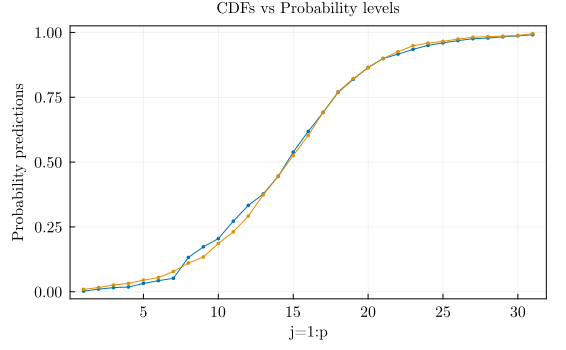

In [23]:
# _ probabilities
plt_prbs = plot(1:shared_pars.js, out_d_h[2], title="CDFs vs Probability levels", l=1, m=2, msw=0, xlabel="j=1:p", ylabel="Probability predictions", label="")

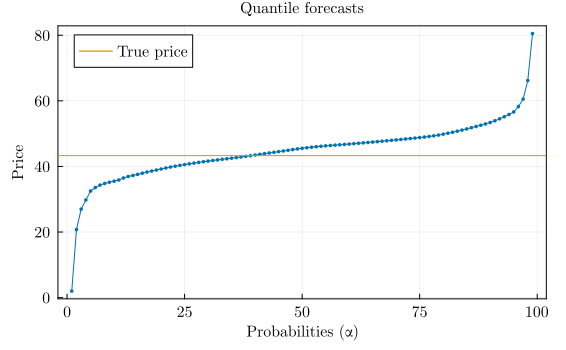

In [24]:
# _ quantile function
plt_qts = plot(out_d_h[1]', title="Quantile forecasts", l=1, m=2, msw=0, xlabel="Probabilities (α)", ylabel="Price", label="")
plt_qts = hline!([ym[day_t,h_hour]], label="True price")

Plot pinball loss for day_t,h_hour

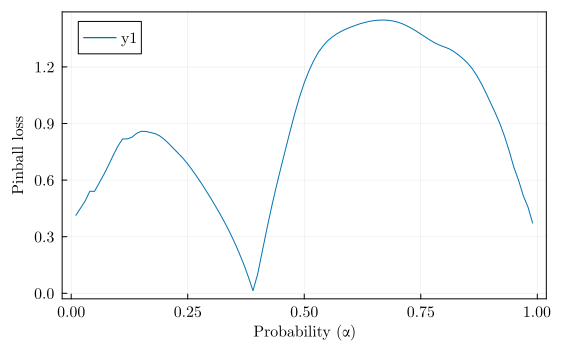

In [25]:
plt_pq = plot(collect(1:99) ./ 100, pq_mat', ylabel="Pinball loss", xlabel="Probability (α)")